# Training MNIST classifier using ScRRAMBLe

In [3]:
import jax
import math
import jax.numpy as jnp
import optax
import flax
from flax import nnx
from flax.nnx.nn import initializers
from typing import Callable
import json
import os
import pickle
import numpy as np
from collections import defaultdict
from functools import partial
from tqdm.notebook import tqdm
import pandas as pd

from utils import clipping_ste, intercore_connectivity, plot_connectivity_matrix, load_mnist
from models import ScRRAMBLeLayer, ScRRAMBLeClassifier


import tensorflow_datasets as tfds  # TFDS to download MNIST.
import tensorflow as tf  # TensorFlow / `tf.data` operations.




import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.cm import get_cmap
import seaborn as sns

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Defining a classifier

In [4]:
class ScRRAMBLeMNIST(nnx.Module):
    """
    MNIST Classifier using ScRRAMBLE architecture
    """

    def __init__(
        self,
        input_vector_size: int,
        input_cores: int,
        output_cores: int,
        avg_slot_connectivity: int, 
        slots_per_core: int,
        slot_length: int,
        activation: Callable,
        rngs: nnx.Rngs,
        group_size: int,
        core_length: int = 256,
        threshold: float = 0.0,
        noise_sd: float = 0.05,


    ):

        self.input_vector_size = input_vector_size
        self.input_cores = input_cores
        self.output_cores = output_cores
        self.avg_slot_connectivity = avg_slot_connectivity
        self.slots_per_core = slots_per_core
        self.slot_length = slot_length
        self.rngs = rngs
        self.group_size = group_size
        self.core_length = core_length
        self.threshold = threshold
        self.noise_sd = noise_sd
        self.activation = partial(activation, threshold=threshold, noise_sd=noise_sd, key=rngs.activation())

        # define the scrramble layer
        self.scrramble_layer = ScRRAMBLeLayer(
            input_vector_size=input_vector_size,
            input_cores=input_cores,
            output_cores=output_cores,
            avg_slot_connectivity=avg_slot_connectivity,
            slots_per_core=slots_per_core,
            slot_length=slot_length,
            activation=activation,
            rngs=rngs,
            core_length=core_length,
            threshold=threshold,
            noise_sd=noise_sd
        )

    @partial(nnx.jit, static_argnames=['output_coding'])
    def __call__(self, x, output_coding: str = 'population'):
        """
        Forward pass for the ScRRAMBLe MNIST classifier
        Args:
            x: jax.Array, input data. Assumed to be flattened MNIST image. No batch.
            output_coding: str, specifies how the binary output should be interpreted. Choices are: ['population', 'svm', ...]. Only 'population' is implemented so far.
        Returns:
            out: jax.Array, output of calssifier with population coding applied. (batch_size, group_size)
        """

        # reshape the image
        # print(x.shape)
        x = jax.image.resize(x, (x.shape[0], 32, 32, 1), method='nearest')
        x = x.reshape(x.shape[0], -1)

        # using vmap do the forward pass
        y = nnx.vmap(self.scrramble_layer, in_axes=0)(x)

        # check if population coding is used
        if output_coding == 'population':

            # truncation
            y_reshaped = y.reshape(y.shape[0], y.shape[1], -1)
            y_reshaped = y_reshaped[..., :250]

            y_reshaped = y_reshaped.reshape(y_reshaped.shape[0], self.group_size, -1)
            y_reshaped = jnp.mean(y_reshaped, axis=-1)
            
            return y_reshaped
            
        else:
            raise NotImplementedError("Non-population coding not implemented yet.")
        

(10, 10)


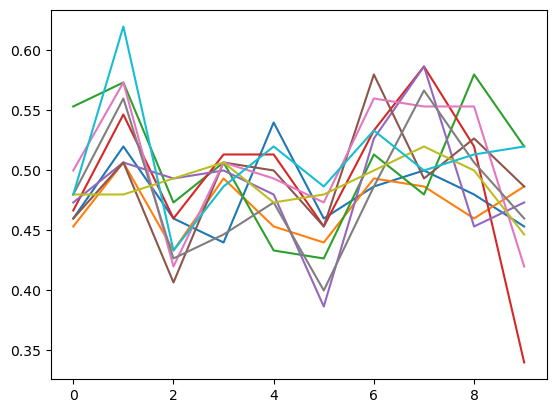

In [5]:
# testing forward pass through the model
rngs_test = nnx.Rngs(params=0, activation=1, permute=2)
x_test = jax.random.normal(rngs_test.params(), (10, 28, 28, 1))
model_test = ScRRAMBLeMNIST(
    input_vector_size=32*32,
    input_cores=5,
    output_cores=6,
    avg_slot_connectivity=4,
    slots_per_core=4,
    slot_length=64,
    activation=clipping_ste,
    rngs=rngs_test,
    group_size=10,
    core_length=256,
    threshold=0.0,
    noise_sd=0.05
)

nnx.display(model_test)
y_test = model_test(x_test)
print(y_test.shape)
plt.plot(y_test.T)

In [6]:
15360%100

60

## Define dataloaders

In [7]:
data_dir = "/local_disk/vikrant/datasets"
dataset_dict = {
    'batch_size': 64,
    'train_steps': 5000,
    'binarize': True,
    'greyscale': True,
    'data_dir': data_dir,
    'seed': 101,
    'shuffle_buffer': 1024,
    'threshold' : 0.5, # binarization threshold, not to be confused with the threshold in the model
    'eval_every': 200,
}

train_ds, test_ds = load_mnist(
    batch_size=dataset_dict['batch_size'],
    train_steps=dataset_dict['train_steps'],
    binarize=dataset_dict['binarize'],
    greyscale=dataset_dict['greyscale'],
    data_dir=dataset_dict['data_dir'],
    seed=dataset_dict['seed'],
    shuffle_buffer=dataset_dict['shuffle_buffer'],
    threshold=dataset_dict['threshold'],
)





I0000 00:00:1746756760.562032  992484 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7126 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:21:00.0, compute capability: 8.9


2025-05-08 19:12:41.500338: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


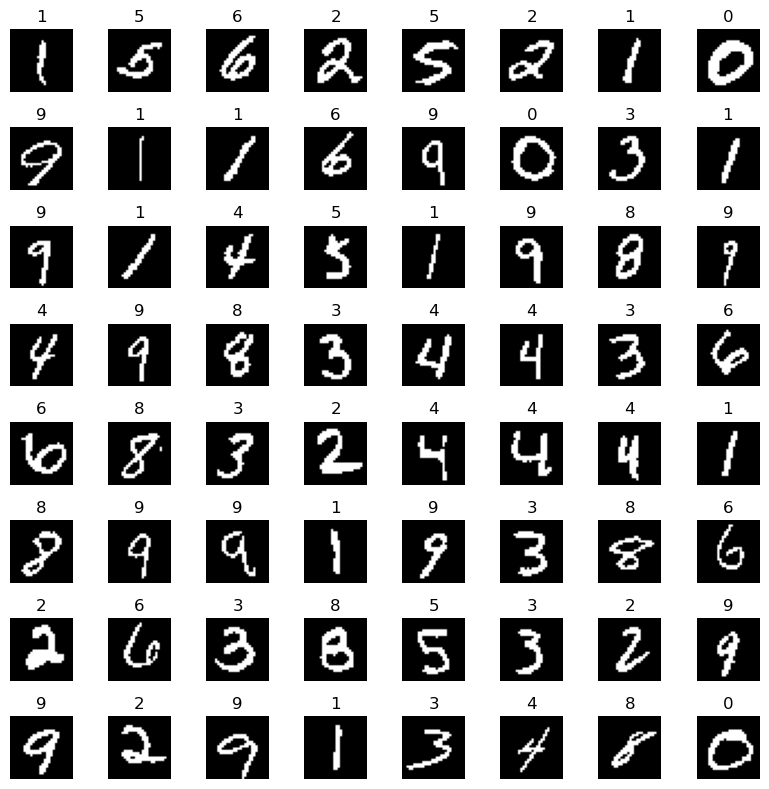

In [8]:
# plot the first batch
train_batch = train_ds.as_numpy_iterator().next()

fig, axs = plt.subplots(8, 8, figsize=(8,8))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(train_batch['image'][i, ..., 0], cmap='gray')
    ax.set_title(f"{train_batch['label'][i]}")
    ax.axis('off')

plt.tight_layout()

## Defining training functions


In [9]:
def loss_fn(model: ScRRAMBLeMNIST, batch):
  logits = model(batch['image'])
  loss = optax.softmax_cross_entropy_with_integer_labels(
    logits=logits, labels=batch['label']
  ).mean()
  return loss, logits

@nnx.jit
def train_step(model: ScRRAMBLeMNIST, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
  """Train for a single step."""
  grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch['label'])  # In-place updates.
  optimizer.update(grads)  # In-place updates.

@nnx.jit
def eval_step(model: ScRRAMBLeMNIST, metrics: nnx.MultiMetric, batch):
  loss, logits = loss_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch['label'])  # In-place updates.


## Training pipeline

In [31]:
model = ScRRAMBLeMNIST(
    input_vector_size=32*32,
    input_cores=10,
    output_cores=8,
    avg_slot_connectivity=6,
    slots_per_core=4,
    slot_length=64,
    activation=clipping_ste,
    rngs=rngs_test,
    group_size=10,
    core_length=256,
    threshold=0.0,
    noise_sd=0.05
)

# optimizers
hyperparameters = {
    'learning_rate': 5e-4,
    'momentum': 0.9, 
    'weight_decay': 1e-2
}

optimizer = nnx.Optimizer(
    model,
    optax.adamw(learning_rate=hyperparameters['learning_rate'], weight_decay=hyperparameters['weight_decay'])
)

metrics = nnx.MultiMetric(
    accuracy=nnx.metrics.Accuracy(),
    loss=nnx.metrics.Average('loss')
)

nnx.display(optimizer)


In [32]:
metrics_history = {
'train_loss': [],
'train_accuracy': [],
'test_loss': [],
'test_accuracy': [],
}

eval_every = dataset_dict['eval_every']
train_steps = dataset_dict['train_steps']

for step, batch in enumerate(train_ds.as_numpy_iterator()):
  # Run the optimization for one step and make a stateful update to the following:
  # - The train state's model parameters
  # - The optimizer state
  # - The training loss and accuracy batch metrics

  train_step(model, optimizer, metrics, batch)

  if step > 0 and (step % eval_every == 0 or step == train_steps - 1):  # One training epoch has passed.
    # Log the training metrics.
    for metric, value in metrics.compute().items():  # Compute the metrics.
      metrics_history[f'train_{metric}'].append(value)  # Record the metrics.
    metrics.reset()  # Reset the metrics for the test set.

    # Compute the metrics on the test set after each training epoch.
    for test_batch in test_ds.as_numpy_iterator():
      eval_step(model, metrics, test_batch)

    # Log the test metrics.
    for metric, value in metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)
    metrics.reset()  # Reset the metrics for the next training epoch.

    print(f"Step {step}: Test loss: {metrics_history['test_loss'][-1]}, Accuracy: {metrics_history['test_accuracy'][-1]}")

best_accuracy = max(metrics_history['test_accuracy'])
print(f"Best accuracy: {best_accuracy}")

Step 200: Test loss: 1.5735143423080444, Accuracy: 0.8627804517745972
Step 400: Test loss: 1.5552916526794434, Accuracy: 0.8756009936332703
Step 600: Test loss: 1.5427368879318237, Accuracy: 0.8896234035491943
Step 800: Test loss: 1.5376348495483398, Accuracy: 0.9048477411270142
Step 1000: Test loss: 1.528954267501831, Accuracy: 0.9192708730697632
Step 1200: Test loss: 1.5277764797210693, Accuracy: 0.908052921295166
Step 1400: Test loss: 1.5231894254684448, Accuracy: 0.9252804517745972
Step 1600: Test loss: 1.519353985786438, Accuracy: 0.9286859035491943
Step 1800: Test loss: 1.5179193019866943, Accuracy: 0.9321914911270142
Step 2000: Test loss: 1.5167549848556519, Accuracy: 0.935396671295166
Step 2200: Test loss: 1.5141104459762573, Accuracy: 0.9419070482254028
Step 2400: Test loss: 1.5134390592575073, Accuracy: 0.94140625
Step 2600: Test loss: 1.5128211975097656, Accuracy: 0.9387019276618958
Step 2800: Test loss: 1.5104448795318604, Accuracy: 0.9424078464508057
Step 3000: Test loss: 